In [62]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
import numpy as np
import matplotlib.pyplot as plt
from rl_envs_forge.envs.network_graph.network_graph import NetworkGraph

from algos import *

In [64]:

def init_env():
    connectivity_matrix = np.array(
        [
            # 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
            [0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],  # 1
            [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # 2
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 3
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 4
            [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 5
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],  # 6
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],  # 7
            [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # 8
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 9
            [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],  # 10
            [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0],  # 11
            [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1],  # 12
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # 13
            [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # 14
            [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # 15
        ]
    )

    desired_centrality = np.array(
        [0.08, # 1
        0.06, # 2
        0.14, # 3
        0.08, # 4
        0.04, # 5
        0.02, # 6
        0.06, # 7
        0.03, # 8
        0.04, # 9
        0.08, # 10
        0.13, # 11
        0.06, # 12
        0.04, # 13
        0.07, # 14
        0.07] # 15
    )  # Example centrality

    initial_opinions = np.linspace(0, 1, len(desired_centrality))

    env = NetworkGraph(
        connectivity_matrix=connectivity_matrix,
        desired_centrality=desired_centrality,
        initial_opinions=initial_opinions,
        max_u=0.2,
        budget=10.0,
        desired_opinion=1.0,
        tau=0.01,
        max_steps=100
    )

    env.reset()
    
    return env

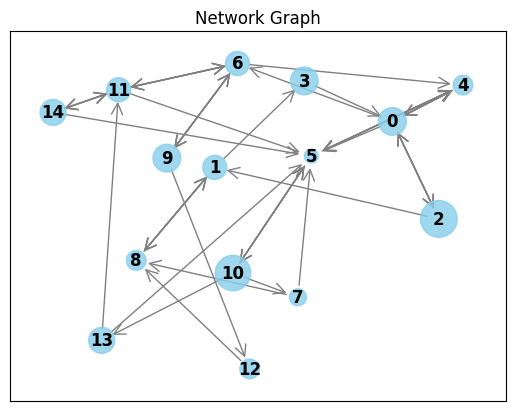

array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
       0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ])

In [65]:
env = init_env()
env.render(mode="matplotlib")
env.reset()

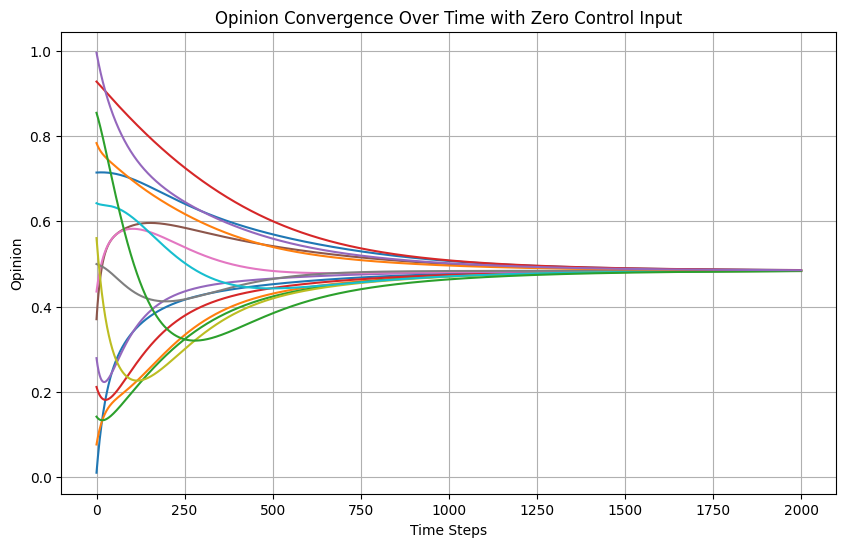

In [66]:
# Define the number of steps for which to apply the zero control input
num_steps = 2000

# Initialize an array to store opinions over time
opinions_over_time = np.zeros((num_steps, env.num_agents))

# Run the simulation with zero control input
for i in range(num_steps):
    no_action_u = np.zeros(env.num_agents)  # Zero control input
    opinions, reward, done, truncated, info = env.step(no_action_u)
    opinions_over_time[i] = opinions

plot_opinions_over_time(opinions_over_time)

In [67]:

env = init_env()

budget = 2

# Applying the optimal control strategy in the environment
optimal_u = optimal_control_action(env, budget=budget)
print(optimal_u)

opinions, reward, done, truncated, info = env.step(optimal_u)
opinions

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


array([0.10915194, 0.16878396, 0.2274811 , 0.29020245, 0.35105879,
       0.43327255, 0.49164426, 0.54970502, 0.6045062 , 0.6781619 ,
       0.74290748, 0.80511562, 0.86900497, 0.93494205, 0.99589341])

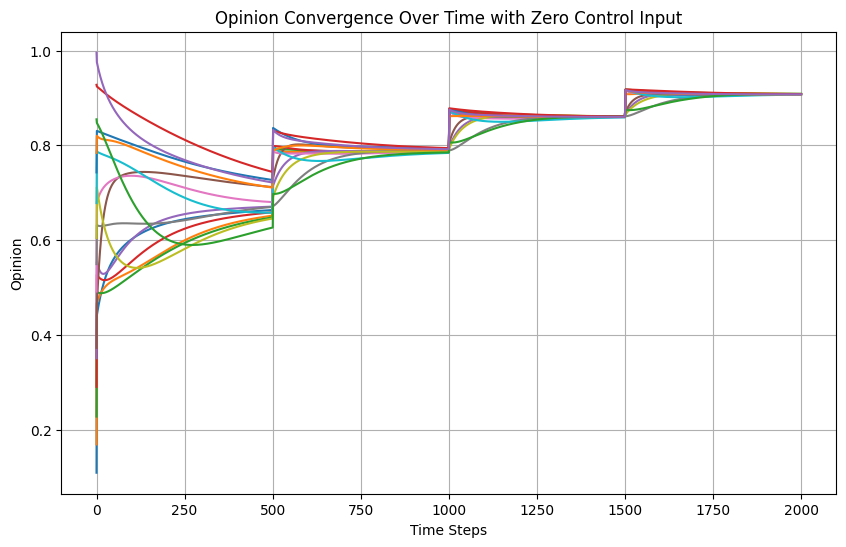

In [68]:
env = init_env()

# Define the number of steps for which to apply the zero control input
num_steps = 2000
k = 500  # Apply optimal control every k steps
N = 5  # Number of consecutive steps to apply optimal control
budget = 1  # Example budget

# Initialize an array to store opinions over time
opinions_over_time = np.zeros((num_steps, env.num_agents))

# Run the simulation
for i in range(num_steps):
    if i % k == 0:
        # Apply the optimal control every k steps for N consecutive steps
        for j in range(N):
            if i + j < num_steps:
                optimal_u = optimal_control_action(env, budget=budget)
                # print(f"Applying optimal control at step {i + j}: {optimal_u}")
                opinions, reward, done, truncated, info = env.step(optimal_u)
                opinions_over_time[i + j] = opinions
        # Skip the next N-1 steps as they are already processed
        i += N - 1
    else:
        # Apply zero control input at other steps
        optimal_u = np.zeros(env.num_agents)
        opinions, reward, done, truncated, info = env.step(optimal_u)
        opinions_over_time[i] = opinions

# Plot the collected opinions over time
plot_opinions_over_time(opinions_over_time)

In [72]:
env = init_env()
M = 3 # Number of campaigns
Q = 15  # Total budget

optimal_budget_allocation = brute_force_strategy(env, M, Q)
print("Optimal budget allocation:", optimal_budget_allocation)

Optimal budget allocation: [2 2 2 2]


In [70]:
env = init_env()

# Example usage with the environment
M = 5  # Number of campaigns
Q = 20  # Total budget

optimal_budget_allocation = dynamic_programming_strategy(env, M, Q)
print("Optimal budget allocation for each campaign:", optimal_budget_allocation)


Optimal budget allocation for each campaign: [4 3 3 3 3 4]
